In [1]:
import numpy as np
import pandas as pd
import sys

path='/home/jbohn/jupyter/personal/Kernel_Learning/'
sys.path.append(path)

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from Data.clean_data import clean_quotes

from Features.feature_preprocessing import generate_features_from_quotes

from LOB_Analysis.batch_data import batch_solve_mkl, batch_features
from LOB_Analysis.batch_kernel import train_svm_batch, predict_svm_batch
from LOB_Analysis.iterate_daily_batch import daily_batch



### Fetch Raw Quote Data 

- Quotes for AAPL across  NASDAQ : Exchange N 
- Data in example below is for Jan 2, 2020 however for results data is cleaned and features are generated in bulk across Jan

### Clean & Preprocessing

- Drops market quotes outside of open hours
- Criteria for invalid quotes (inverted spread, zero price or volume)
- Standardizes Participant Timestamp as time index

In [2]:
cleaned_quotes=pd.read_csv(path+'Data/cleaned_AAPL_quotes_2020-01-02.csv',index_col=0)
cleaned_quotes

,Participant_Timestamp,SIP_Timestamp,Exchange,Symbol,Bid_Price,Bid_Size,Offer_Price,Offer_Size,Quote_Condition,Sequence_Number,...,Best_Bid_Exchange,Best_Bid_Price,Best_Bid_Size,Best_Offer_Exchange,Best_Offer_Price,Best_Offer_Size,LULD_NBBO_Indicator,Security_Status_Indicator,National_BBO_Ind,date
2020-01-02 09:30:03.296828,140,2020-01-02 09:30:03.297207,N,AAPL,295.70,1.0,296.75,6.0,R,288805,...,Q,296.19,2.0,Z,296.26,2.0,A,,2,2020-01-02
2020-01-02 09:30:05.489204,141,2020-01-02 09:30:05.489581,N,AAPL,296.14,4.0,296.75,5.0,R,296557,...,N,296.14,4.0,Z,296.19,4.0,A,,2,2020-01-02
2020-01-02 09:30:05.663684,142,2020-01-02 09:30:05.664062,N,AAPL,295.70,1.0,296.75,5.0,R,297100,...,Q,296.13,1.0,Z,296.16,2.0,A,,2,2020-01-02
2020-01-02 09:30:06.278858,143,2020-01-02 09:30:06.279237,N,AAPL,294.05,1.0,296.12,2.0,R,299138,...,Q,296.03,1.0,Z,296.07,4.0,A,,2,2020-01-02
2020-01-02 09:30:14.710996,144,2020-01-02 09:30:14.711372,N,AAPL,295.12,1.0,295.74,1.0,R,318631,...,Z,295.65,6.0,N,295.74,1.0,A,,2,2020-01-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-02 15:59:41.175398,87570,2020-01-02 15:59:41.175774,N,AAPL,300.41,2.0,300.66,1.0,R,30603857,...,Z,300.41,3.0,Q,300.44,4.0,A,,2,2020-01-02
2020-01-02 15:59:46.113982,87571,2020-01-02 15:59:46.114358,N,AAPL,300.29,3.0,300.46,1.0,R,30643992,...,Z,300.44,2.0,P,300.46,2.0,A,,2,2020-01-02
2020-01-02 15:59:50.118942,87572,2020-01-02 15:59:50.119320,N,AAPL,300.29,3.0,300.66,1.0,R,30672299,...,Q,300.37,3.0,Q,300.40,4.0,A,,2,2020-01-02
2020-01-02 15:59:52.913707,87573,2020-01-02 15:59:52.914082,N,AAPL,300.29,3.0,300.66,1.0,R,30696052,...,Q,300.36,1.0,Q,300.39,2.0,A,,2,2020-01-02


### Feature Generation

- Generates set of features off quote data 
- Performs time aggregation to 5 second 
- Labels outcome; price direction relative to next interval

In [3]:
labelled_data=generate_features_from_quotes(cleaned_quotes,time_agg=5,save=False)
labelled_data

,Exchange,Symbol,Best_Bid_Price,FB0,Best_Offer_Price,FA0,FB2,FA2,p_time,Next_Best_Bid,Next_Best_Offer,outcome
last_interval,,,,,,,,,,,,
2020-01-02 09:30:05,N,AAPL,296.14,4.0,296.19,4.0,2.0,2.0,2020-01-02 09:30:05.489204,295.65,295.74,-1
2020-01-02 09:30:10,N,AAPL,295.65,6.0,295.74,1.0,5.0,-3.0,2020-01-02 09:30:14.710996,295.52,295.63,-1
2020-01-02 09:30:15,N,AAPL,295.52,3.0,295.63,1.0,2.0,0.0,2020-01-02 09:30:17.317319,295.54,295.68,0
2020-01-02 09:30:25,N,AAPL,295.54,2.0,295.68,1.0,-1.0,0.0,2020-01-02 09:30:28.784184,295.67,295.79,0
2020-01-02 09:30:30,N,AAPL,295.67,2.0,295.79,1.0,0.0,0.0,2020-01-02 09:30:34.896431,295.71,295.82,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-02 15:59:25,N,AAPL,300.43,13.0,300.44,1.0,10.0,0.0,2020-01-02 15:59:25.680175,300.41,300.44,0
2020-01-02 15:59:40,N,AAPL,300.41,3.0,300.44,4.0,-1.0,3.0,2020-01-02 15:59:41.175398,300.44,300.46,0
2020-01-02 15:59:45,N,AAPL,300.44,2.0,300.46,2.0,-1.0,-2.0,2020-01-02 15:59:46.113982,300.37,300.40,-1


### Batch Features

- For computational feasiblity will retrain model off batched data looking to evaluate performance in subsequent interval
- Batches features and outcomes in size batch_size which model will be trained from

### Train Single Kernel across batched dataset

In [4]:
start='2020-01-01'
end='2020-01-30'

kernel_type='gaussian'
order=1
batch_size=300


single_gaussian_accuracy,single_gaussian_precision=daily_batch(start,end,kernel_type,order,batch_size)

[Errno 2] No such file or directory: '/home/jbohn/jupyter/personal/Kernel_Learning/Features/Cleaned_Features/labeled_data_2020-01-01.csv'
No data for 2020-01-01 00:00:00
Batch  0 Last Interval 2020-01-02 09:30:05 complete with weights  [1.]
Batch  300 Last Interval 2020-01-02 09:36:35 complete with weights  [1.]
Batch  600 Last Interval 2020-01-02 09:43:00 complete with weights  [1.]
Batch  900 Last Interval 2020-01-02 09:49:49 complete with weights  [1.]
Batch  1200 Last Interval 2020-01-02 09:56:28 complete with weights  [1.]
Batch  1500 Last Interval 2020-01-02 10:02:52 complete with weights  [1.]
Batch  1800 Last Interval 2020-01-02 10:09:21 complete with weights  [1.]
Batch  2100 Last Interval 2020-01-02 10:15:28 complete with weights  [1.]
Batch  2400 Last Interval 2020-01-02 10:21:48 complete with weights  [1.]
Batch  2700 Last Interval 2020-01-02 10:27:44 complete with weights  [1.]
Batch  3000 Last Interval 2020-01-02 10:33:39 complete with weights  [1.]
Batch  3300 Last Inter

In [ ]:
start='2020-01-01'
end='2020-01-30'

kernel_type='linear'
order=1
batch_size=300


single_linear_accuracy,single_linear_precision=daily_batch(start,end,kernel_type,order,batch_size)

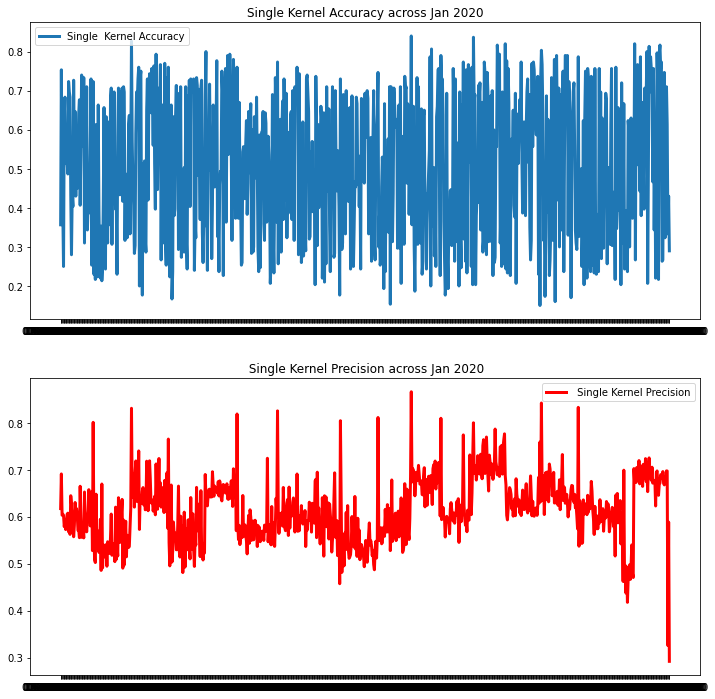

In [5]:
fig,axis=plt.subplots(2,1,figsize=(12,12))
axis[0].plot(list(single_gaussian_accuracy.keys()),list(single_gaussian_accuracy.values()),lw=1,label='Single  Kernel Accuracy')
axis[0].set_title('Single Kernel Accuracy across Jan 2020')
axis[1].plot(list(single_gaussian_precision.keys()),list(single_gaussian_precision.values()),lw=1,label=' Single Kernel Precision',color='red')
axis[1].set_title(' Single Kernel Precision across Jan 2020')
axis[0].legend()
axis[1].legend()
xfmt = DateFormatter('%d-%m-%y %H:%M')
axis[0].xaxis.set_major_formatter(xfmt)
axis[1].xaxis.set_major_formatter(xfmt)

In [6]:
accuracy_df=pd.DataFrame.from_dict(single_gaussian_accuracy,orient='index')
accuracy_df.describe()

,0
count,843.000000
mean,0.507805
std,0.181389
min,0.150000
25%,0.343333
50%,0.513333
75%,0.680000
max,0.840000


In [7]:
precision_df=pd.DataFrame.from_dict(single_gaussian_precision,orient='index')
precision_df.describe()

,0
count,843.000000
mean,0.614362
std,0.067483
min,0.292058
25%,0.569157
50%,0.612861
75%,0.661340
max,0.866301


### Multi-Kernel Training and Evaluation (3 Kernels)


In [8]:
start='2020-01-01'
end='2020-01-30'

kernel_type='gaussian'
order=5
batch_size=300


all_accuracy,all_precision=daily_batch(start,end,kernel_type,order,batch_size)

[Errno 2] No such file or directory: '/home/jbohn/jupyter/personal/Kernel_Learning/Features/Cleaned_Features/labeled_data_2020-01-01.csv'
No data for 2020-01-01 00:00:00
Batch  0 Last Interval 2020-01-02 09:30:05 complete with weights  [0.         0.20949707 0.23442258 0.26343602 0.29264433]
Batch  300 Last Interval 2020-01-02 09:36:35 complete with weights  [0.19202175 0.20071676 0.20225626 0.20252167 0.20248356]
Batch  600 Last Interval 2020-01-02 09:43:00 complete with weights  [0.         0.24182252 0.2513387  0.25310196 0.25373683]
Batch  900 Last Interval 2020-01-02 09:49:49 complete with weights  [0.19214868 0.19747216 0.2012086  0.20372638 0.20544418]
Batch  1200 Last Interval 2020-01-02 09:56:28 complete with weights  [0.         0.25989127 0.25393451 0.2459001  0.24027412]
Batch  1500 Last Interval 2020-01-02 10:02:52 complete with weights  [0.         0.22418197 0.24206034 0.25946632 0.27429137]
Batch  1800 Last Interval 2020-01-02 10:09:21 complete with weights  [1. 0. 0. 0

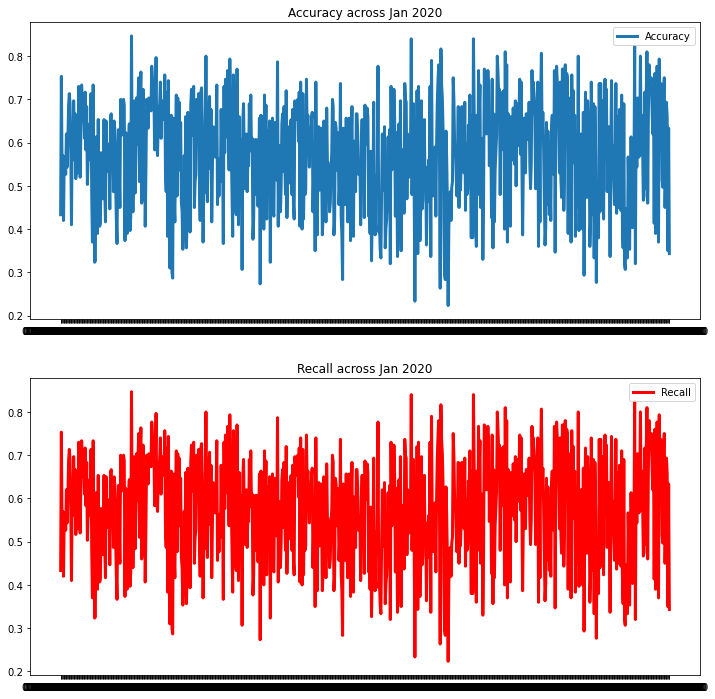

In [ ]:
fig,axis=plt.subplots(2,1,figsize=(12,12))
axis[0].plot(list(all_accuracy.keys()),list(all_accuracy.values()),lw=3,label='Multiple  Kernel Accuracy')
axis[0].set_title('Multiple Kernel Accuracy across Jan 2020')
axis[1].plot(list(all_precision.keys()),list(all_precision.values()),lw=3,label=' Multiple Kernel Precision',color='red')
axis[1].set_title('Multiple Kernel Precision across Jan 2020')
axis[0].legend()
axis[1].legend()
xfmt = DateFormatter('%d-%m-%y %H:%M')
axis[0].xaxis.set_major_formatter(xfmt)
axis[1].xaxis.set_major_formatter(xfmt)

In [ ]:
accuracy_df=pd.DataFrame.from_dict(all_accuracy,orient='index')
accuracy_df.describe()

,0
count,843.000000
mean,0.571404
std,0.124849
min,0.223333
25%,0.476667
50%,0.583333
75%,0.670000
max,0.846667


In [ ]:
precision_df=pd.DataFrame.from_dict(all_precision,orient='index')
precision_df.describe()


,0
count,843.000000
mean,0.571404
std,0.124849
min,0.223333
25%,0.476667
50%,0.583333
75%,0.670000
max,0.846667
